In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from copy import deepcopy

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, \
    classification_report, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler


In [6]:
df_save = pd.read_csv('./data/dataset_lab1.csv', sep=',')
df = deepcopy(df_save)
df.drop(index=4)

,URL,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,...,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
0,M0_109,16,7,iso-8859-1,nginx,263.0,NaN,NaN,10/10/2015 18:21,NaN,...,0,2,700,9,10,1153,832,9,2.0,1
1,B0_2314,16,6,UTF-8,Apache/2.4.10,15087.0,NaN,NaN,NaN,NaN,...,7,4,1230,17,19,1265,1230,17,0.0,0
2,B0_911,16,6,us-ascii,Microsoft-HTTPAPI/2.0,324.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0.0,0
3,B0_113,17,6,ISO-8859-1,nginx,162.0,US,AK,7/10/1997 4:00,12/09/2013 0:45,...,22,3,3812,39,37,18784,4380,39,8.0,0
5,B0_2064,18,7,UTF-8,nginx,NaN,SC,Mahe,3/08/2016 14:30,3/10/2016 3:45,...,6,9,894,11,13,838,894,11,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1776,M4_48,194,16,UTF-8,Apache,NaN,ES,Barcelona,17/09/2008 0:00,2/09/2016 0:00,...,0,0,0,0,3,186,0,0,0.0,1
1777,M4_41,198,17,UTF-8,Apache,NaN,ES,Barcelona,17/09/2008 0:00,2/09/2016 0:00,...,0,0,0,0,2,124,0,0,0.0,1
1778,B0_162,201,34,utf-8,Apache/2.2.16 (Debian),8904.0,US,FL,15/02/1999 0:00,15/07/2015 0:00,...,2,6,6631,87,89,132181,6945,87,4.0,0
1779,B0_1152,234,34,ISO-8859-1,cloudflare-nginx,NaN,US,CA,1/04/1998 0:00,9/12/2016 0:00,...,0,0,0,0,0,0,0,0,0.0,0


In [7]:
df.drop('URL', axis=1, inplace=True)

In [8]:
df.SERVER.unique()

array(['nginx', 'Apache/2.4.10', 'Microsoft-HTTPAPI/2.0', nan, 'Apache/2',
       'nginx/1.10.1', 'Apache', 'Apache/2.2.15 (Red Hat)',
       'Apache/2.4.23 (Unix) OpenSSL/1.0.1e-fips mod_bwlimited/1.4',
       'openresty/1.11.2.1', 'Apache/2.2.22', 'Apache/2.4.7 (Ubuntu)',
       'nginx/1.12.0',
       'Apache/2.4.12 (Unix) OpenSSL/1.0.1e-fips mod_bwlimited/1.4',
       'Oracle-iPlanet-Web-Server/7.0', 'cloudflare-nginx', 'nginx/1.6.2',
       'openresty', 'Heptu web server', 'Pepyaka/1.11.3', 'nginx/1.8.0',
       'nginx/1.10.1 + Phusion Passenger 5.0.30',
       'Apache/2.2.29 (Amazon)', 'Microsoft-IIS/7.5', 'LiteSpeed',
       'Apache/2.4.25 (cPanel) OpenSSL/1.0.1e-fips mod_bwlimited/1.4',
       'tsa_c', 'Apache/2.2.0 (Fedora)', 'Apache/2.2.22 (Debian)',
       'Apache/2.2.15 (CentOS)', 'Apache/2.4.25',
       'Apache/2.4.25 (Amazon) PHP/7.0.14', 'GSE',
       'Apache/2.4.23 (Unix) OpenSSL/0.9.8e-fips-rhel5 mod_bwlimited/1.4',
       'Apache/2.4.25 (Amazon) OpenSSL/1.0.1k-fips',
 

In [5]:
# filtering CHARSET
df = df[df.CHARSET.notna()]
df.CHARSET = df.CHARSET.apply(lambda x: x.lower())
counts = df['CHARSET'].value_counts()
counts = counts[counts > 1]
df = df.query('CHARSET in @counts.keys()')

In [6]:
df.CHARSET.unique()


array(['iso-8859-1', 'utf-8', 'us-ascii'], dtype=object)

In [7]:
# drop rows with no servers
df = df[df.SERVER.notna()]

In [8]:
df.drop('CONTENT_LENGTH', axis=1, inplace=True)

In [15]:
df.drop(['WHOIS_COUNTRY',
         'WHOIS_STATEPRO',
         'APP_BYTES',
         'APP_PACKETS',
         'WHOIS_REGDATE',
         'WHOIS_UPDATED_DATE'], axis=1, inplace=True)

In [9]:
df = df[df.DNS_QUERY_TIMES.notna()]

In [11]:
servers = df.SERVER.value_counts()
servers = servers[servers > 10]
servers_list = tuple(servers.index.to_list())


def my_server(_server):
    return _server if _server in servers_list else 'other'

In [12]:
df.SERVER = df.SERVER.apply(my_server)

In [13]:
df

,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
0,16,7,iso-8859-1,nginx,NaN,NaN,10/10/2015 18:21,NaN,7,0,2,700,9,10,1153,832,9,2.0,1
1,16,6,utf-8,other,NaN,NaN,NaN,NaN,17,7,4,1230,17,19,1265,1230,17,0.0,0
2,16,6,us-ascii,Microsoft-HTTPAPI/2.0,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0.0,0
3,17,6,iso-8859-1,nginx,US,AK,7/10/1997 4:00,12/09/2013 0:45,31,22,3,3812,39,37,18784,4380,39,8.0,0
5,18,7,utf-8,nginx,SC,Mahe,3/08/2016 14:30,3/10/2016 3:45,11,6,9,894,11,13,838,894,11,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1776,194,16,utf-8,Apache,ES,Barcelona,17/09/2008 0:00,2/09/2016 0:00,0,0,0,0,0,3,186,0,0,0.0,1
1777,198,17,utf-8,Apache,ES,Barcelona,17/09/2008 0:00,2/09/2016 0:00,0,0,0,0,0,2,124,0,0,0.0,1
1778,201,34,utf-8,other,US,FL,15/02/1999 0:00,15/07/2015 0:00,83,2,6,6631,87,89,132181,6945,87,4.0,0
1779,234,34,iso-8859-1,cloudflare-nginx,US,CA,1/04/1998 0:00,9/12/2016 0:00,0,0,0,0,0,0,0,0,0,0.0,0


In [16]:
sc = StandardScaler()
columns_to_standardize = [x for x in df.columns.tolist() if x not in ['CHARSET', 'SERVER', 'Type']]

scaled = sc.fit_transform(df[columns_to_standardize])
df[columns_to_standardize] = scaled

In [17]:
columns_to_dummy = ['CHARSET', 'SERVER']

In [18]:
for col in columns_to_dummy:
    encoded = pd.get_dummies(df[col])
    for enc_col in encoded.columns:
        df[f'{col}_{enc_col}'] = encoded[enc_col]
df.drop(columns_to_dummy, axis=1, inplace=True)

<Axes: >

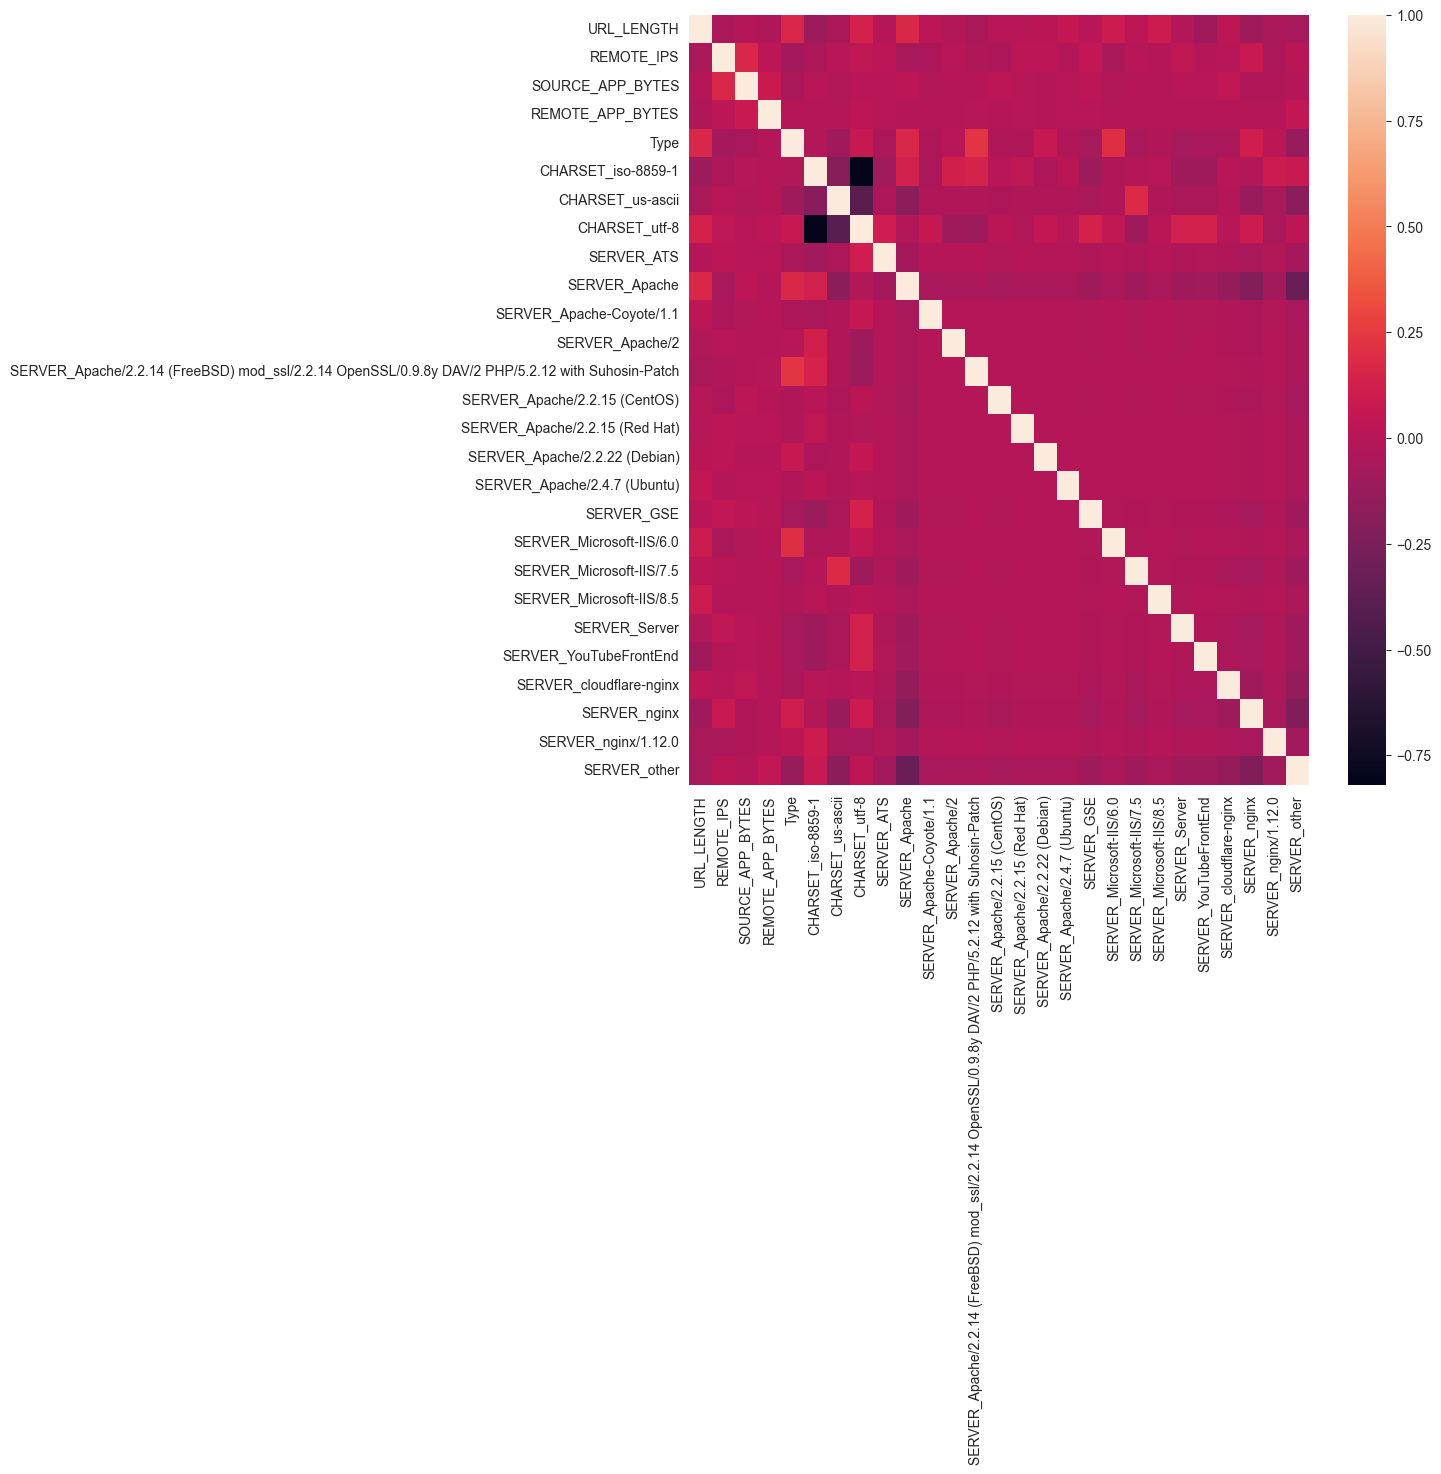

In [20]:
plt.figure(figsize=(10, 10))
sns.heatmap(df.drop(['SERVER_Microsoft-HTTPAPI/2.0',
                     'SOURCE_APP_PACKETS',
                     'REMOTE_APP_PACKETS',
                     'TCP_CONVERSATION_EXCHANGE',
                     'NUMBER_SPECIAL_CHARACTERS',
                     'DIST_REMOTE_TCP_PORT',
                     'DNS_QUERY_TIMES',
                     ], axis=1).corr())


In [21]:
ready_data = df.drop(['SERVER_Microsoft-HTTPAPI/2.0',
                      'SOURCE_APP_PACKETS',
                      'REMOTE_APP_PACKETS',
                      'REMOTE_APP_PACKETS',
                      'TCP_CONVERSATION_EXCHANGE',
                      'NUMBER_SPECIAL_CHARACTERS',
                      'DIST_REMOTE_TCP_PORT',
                      'DNS_QUERY_TIMES',
                      ], axis=1)

ready_data['Type'] = np.abs(ready_data['Type'] - 1)

TRAIN

In [26]:
Y = ready_data['Type'].to_numpy()
X = ready_data.drop(columns=['Type']).to_numpy()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [48]:
def plot_confusion_matrix_and_print_metrics(y_pred, y_true, model_params, model_name=""):
    conf_matrix = confusion_matrix(y_true, y_pred)
    ax = sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 16}, fmt="d")
    if model_name:
        ax.set_title(f"Evaluation Results for {model_name} model with parameters {model_params}", fontsize=14, pad=20)
    ax.set_xlabel("Predicted Values", fontsize=14, labelpad=20)
    ax.xaxis.set_ticklabels(['Benign', 'Malicious'])
    ax.set_ylabel("Actual Values", fontsize=14, labelpad=20)
    ax.yaxis.set_ticklabels(['Benign', 'Malicious'])
    plt.show()

    print(classification_report(y_true, y_pred))


def train_and_evaluate_model(model_name, X_train, X_test, Y_train, Y_test):
    model_class, model_params = MODEL_CLASSES_AND_PARAMETERS[model_name]
    model = model_class(**model_params)
    model.fit(X_train, Y_train)
    y_test_pred = model.predict(X_test)
    plot_confusion_matrix_and_print_metrics(y_test_pred, Y_test, model_params, model_name)
    print("\n" * 5)

In [41]:
MODEL_CLASSES_AND_PARAMETERS = {
    # https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html
    "NAIVE_BAYES": (GaussianNB,
                    {"priors": None, "var_smoothing": 1e-09}),

    # https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
    "LOGISTIC_REGRESSION": (LogisticRegression,
                            {"random_state": 0, "class_weight": None, "solver": "lbfgs", "max_iter": 100}),
}

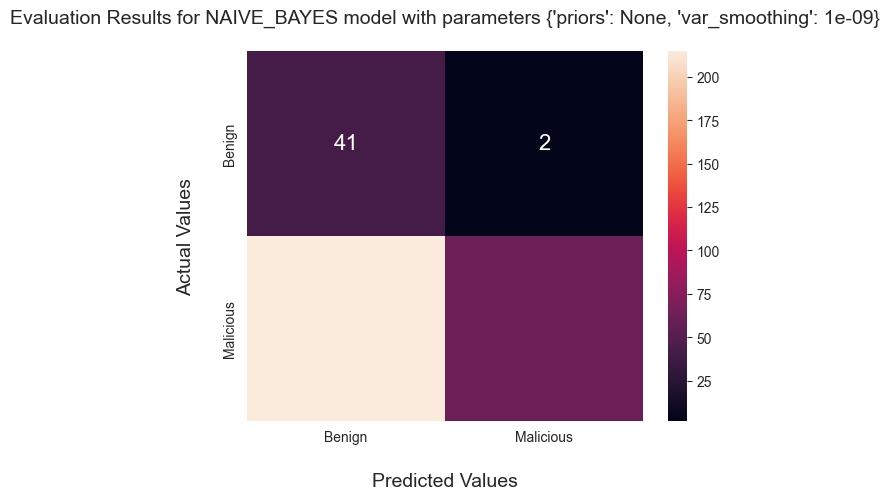

              precision    recall  f1-score   support

           0       0.16      0.95      0.27        43
           1       0.97      0.22      0.36       276

    accuracy                           0.32       319
   macro avg       0.56      0.59      0.32       319
weighted avg       0.86      0.32      0.35       319


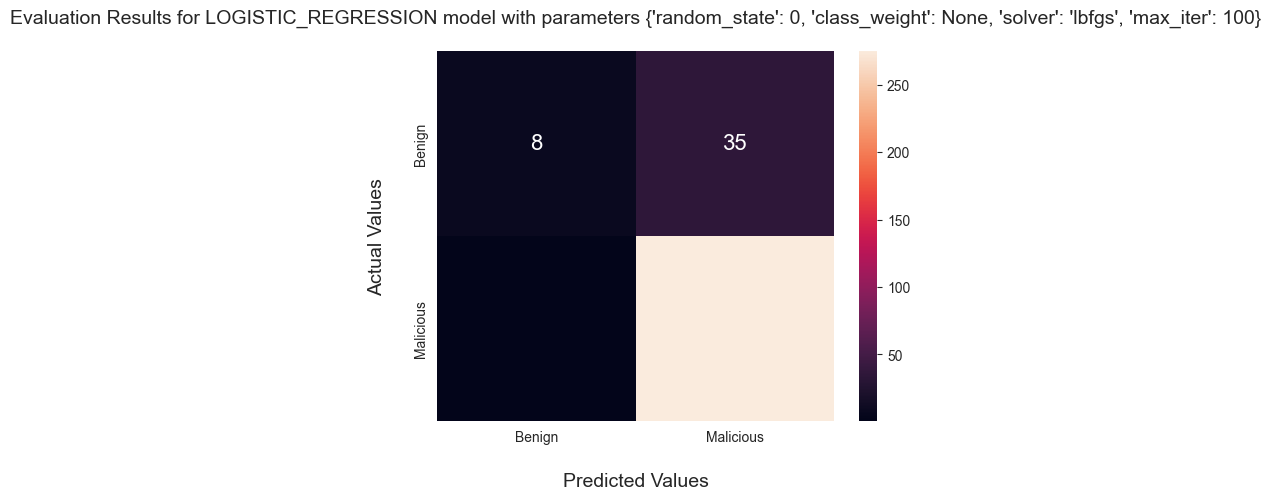

              precision    recall  f1-score   support

           0       0.89      0.19      0.31        43
           1       0.89      1.00      0.94       276

    accuracy                           0.89       319
   macro avg       0.89      0.59      0.62       319
weighted avg       0.89      0.89      0.85       319


In [50]:
for model_name in MODEL_CLASSES_AND_PARAMETERS:
    train_and_evaluate_model(model_name, X_train, X_test, Y_train, Y_test)

In [57]:
best_found_clf = LogisticRegression(random_state=1, solver='lbfgs', penalty='l2')
best_found_clf.fit(X_train, Y_train)

LogisticRegression(random_state=1)

In [52]:
def roc_and_metrics(models, X_test, Y_test):
    ns_probs = [0 for _ in range(len(Y_test))]
    
    for model in models:
        print(model)
        preds = model.predict(X_test)
        probs = model.predict_proba(X_test)[:, 1]
        print(f'\taccuracy: {accuracy_score(preds, Y_test)}')
        print(f'\tprecision: {precision_score(preds, Y_test)}')
        print(f'\trecall: {recall_score(preds, Y_test)}')
        print(f'\tf1: {f1_score(preds, Y_test)}')
        print(f'\troc_auc: {roc_auc_score(preds, Y_test)}')
        fpr, tpr, _ = roc_curve(Y_test, probs)
        plt.plot(fpr, tpr)
        fpr, tpr, _ = roc_curve(Y_test, ns_probs)
        plt.plot(fpr, tpr)

LogisticRegression(random_state=1)
	accuracy: 0.8871473354231975
	precision: 0.9963768115942029
	recall: 0.8870967741935484
	f1: 0.9385665529010239
	roc_auc: 0.8879928315412187


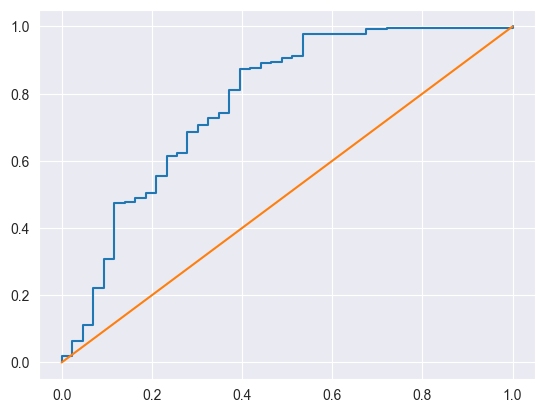

In [58]:
roc_and_metrics([best_found_clf], X_test, Y_test)

In [31]:
ready_data

,URL_LENGTH,REMOTE_IPS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,Type,CHARSET_iso-8859-1,CHARSET_us-ascii,CHARSET_utf-8,SERVER_ATS,SERVER_Apache,...,SERVER_GSE,SERVER_Microsoft-IIS/6.0,SERVER_Microsoft-IIS/7.5,SERVER_Microsoft-IIS/8.5,SERVER_Server,SERVER_YouTubeFrontEnd,SERVER_cloudflare-nginx,SERVER_nginx,SERVER_nginx/1.12.0,SERVER_other
0,-1.486671,-0.305670,-0.210536,-0.040838,0,True,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1,-1.486671,0.292543,-0.208897,-0.034115,1,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,True
2,-1.486671,-0.903884,-0.227408,-0.054891,1,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,-1.450749,-0.006563,0.047456,0.019090,1,True,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
5,-1.414826,1.788077,-0.215146,-0.039790,1,False,False,True,False,False,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1776,4.907524,-0.903884,-0.224686,-0.054891,0,False,False,True,False,True,...,False,False,False,False,False,False,False,False,False,False
1777,5.051213,-0.903884,-0.225593,-0.054891,0,False,False,True,False,True,...,False,False,False,False,False,False,False,False,False,False
1778,5.158981,0.890757,1.706779,0.062415,1,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,True
1779,6.344421,-0.903884,-0.227408,-0.054891,1,True,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False


FOREST FOR FEATURE IMPORTANCE

C:\Users\User\AppData\Local\Temp\ipykernel_1424\4115933802.py:13: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


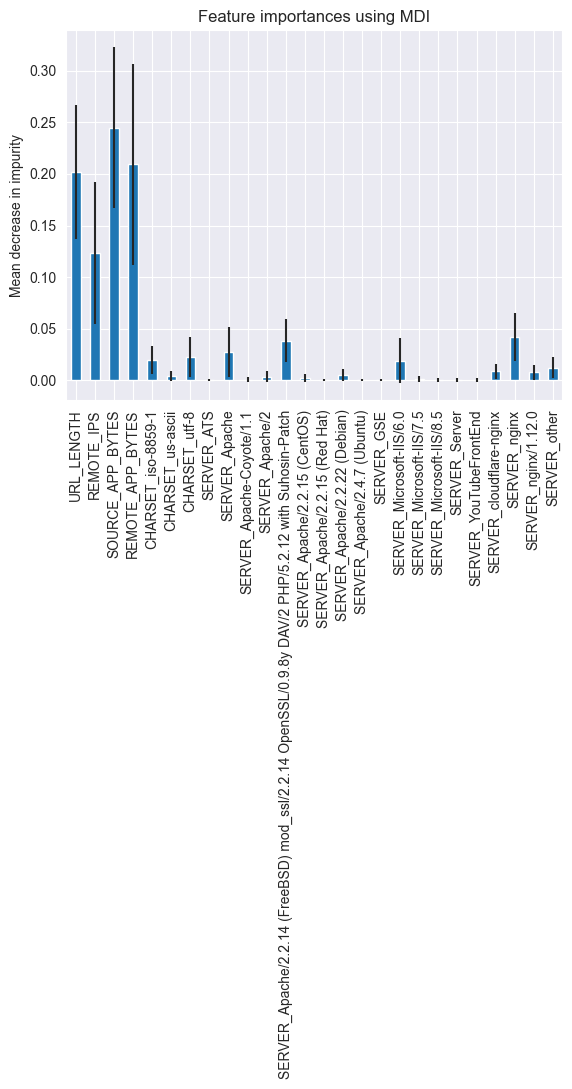

In [35]:
feature_names = [i for i in ready_data.drop('Type', axis=1).columns]
forest = RandomForestClassifier(random_state=0)
forest.fit(X_train, Y_train)

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [46]:
important_data = ready_data[["URL_LENGTH", "REMOTE_IPS", "SOURCE_APP_BYTES", "REMOTE_APP_BYTES", "Type"]]
important_Y = important_data['Type'].to_numpy()
important_X = ready_data.drop(columns=['Type']).to_numpy()
im_X_train, im_X_test, im_Y_train, im_Y_test = train_test_split(important_X, important_Y, test_size=0.2, random_state=0)

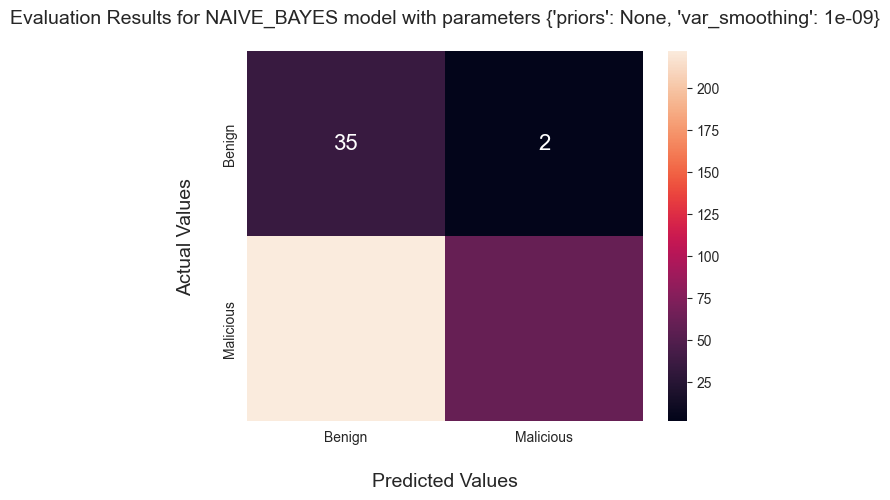

              precision    recall  f1-score   support

           0       0.14      0.95      0.24        37
           1       0.97      0.21      0.35       282

    accuracy                           0.30       319
   macro avg       0.55      0.58      0.29       319
weighted avg       0.87      0.30      0.34       319


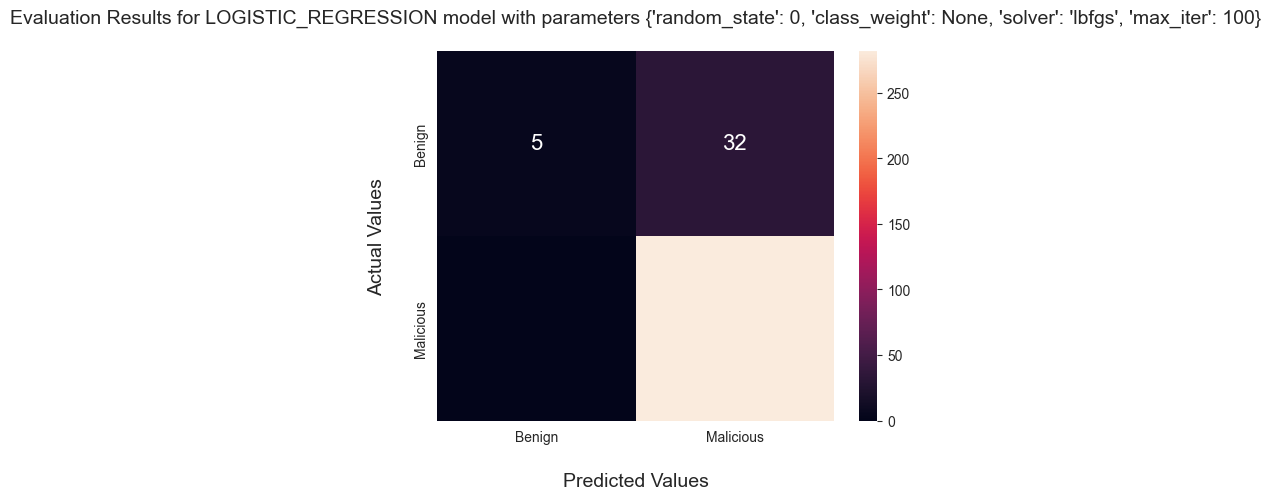

              precision    recall  f1-score   support

           0       1.00      0.14      0.24        37
           1       0.90      1.00      0.95       282

    accuracy                           0.90       319
   macro avg       0.95      0.57      0.59       319
weighted avg       0.91      0.90      0.86       319


In [51]:
for model_name in MODEL_CLASSES_AND_PARAMETERS:
    train_and_evaluate_model(model_name, im_X_train, im_X_test, im_Y_train, im_Y_test)

LogisticRegression(random_state=1)
	accuracy: 0.8996865203761756
	precision: 1.0
	recall: 0.8980891719745223
	f1: 0.9463087248322147
	roc_auc: 0.9490445859872612


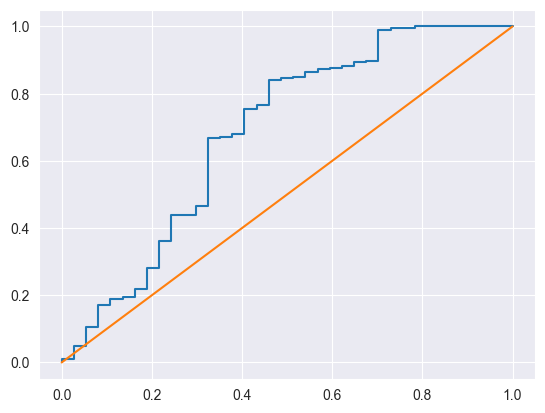

In [56]:
im_clf = LogisticRegression(random_state=1, solver='lbfgs', penalty='l2')
im_clf.fit(im_X_train, im_Y_train)

roc_and_metrics([im_clf], im_X_test, im_Y_test)